<a href="https://colab.research.google.com/github/Tarushfx/News-Classifier/blob/main/News_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML PROJECT**
> TOPIC : NEWS CLASSIFICATION



---

**Problem Statement** : For the last few years, text mining has been gaining significant importance. Since Knowledge is now available to users through variety of sources i.e. electronic media, digital media, print media, and many more. Due to huge availability of text in numerous forms, a lot of unstructured data has been recorded by research experts. News classification is a part of one such problem.

**Possible Solution** : There are numerous ways to convert scattered data into defined structured volume. In this project, for news classification, we have used text classification process.

In [ ]:
# Configuration
# ************* Make sure to add your kaggle.json here ***********
import os
# ********** TODO: hardcoding the Kaggle API key ****************
# with open("kaggle.json", "w") as f:
#   f.write("""YOUR KAGGLE KEYS Go HERE""")
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!chmod 600 kaggle.json

In [ ]:
# Getting the Dataset
!kaggle competitions download -c learn-ai-bbc

import zipfile
DATASET_NAME = "BBC News "
#Unzipping the dataset
for t in ["BBC%20News%20Test.csv.zip", "BBC%20News%20Train.csv.zip"] :
  zip_path = os.path.join(os.getcwd(), t)
  with zipfile.ZipFile(zip_path, 'r') as zip_file:
      zip_file.extractall(os.getcwd())

TRAIN_DATA = os.path.join(os.getcwd(), "BBC News Train.csv")
TEST_DATA = os.path.join(os.getcwd(), "BBC News Test.csv")

BBC%20News%20Sample%20Solution.csv: Skipping, found more recently modified local copy (use --force to force download)
BBC%20News%20Test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
BBC%20News%20Train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
import sklearn

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rcParams['font.size'] = 14
# plt.style.use('seaborn-dark')

In [ ]:
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Dataset

In [ ]:
dataset = pd.read_csv(TRAIN_DATA)
validation_set = pd.read_csv(TEST_DATA)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [ ]:
# CATEGORIES OF NEWS
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [ ]:
# CATEGORY ID FOR EACH UNIQUE CATEGORY
dataset['categoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,categoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [ ]:
category = dataset[["Category","categoryId"]].drop_duplicates().sort_values('categoryId')
category

,Category,categoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [ ]:
# COUNT OF NEWS OF EACH CATEGORY
dataset.groupby('Category').categoryId.count()

Category
business         336
entertainment    273
politics         274
sport            346
tech             261
Name: categoryId, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


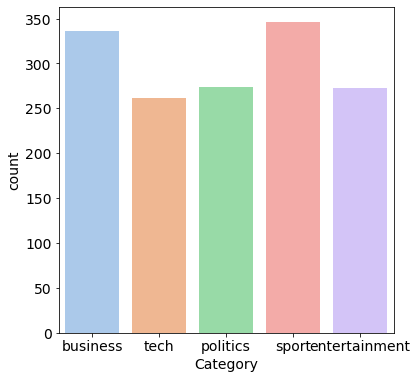

In [ ]:
# df=dataset.groupby('Category').categoryId.count()
sns.countplot(dataset.Category,palette="pastel")
# sns.color_palette("pastel")
fig=plt.gcf()
fig.set_size_inches(6,6)

# df

In [ ]:
text = dataset["Text"] 
text.head()

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
Name: Text, dtype: object

In [ ]:
category = dataset["Category"]
category.head()

0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

# Data Preprocessing

In [ ]:
def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [ ]:
dataset['Text'] = dataset['Text'].apply(preprocessDataset)
text = dataset['Text']
category = dataset['Category']
text.head()

0    worldcom ex bos launch defenc lawyer defend fo...
1    german busi confid slide german busi confid fe...
2    bbc poll indic econom gloom citizen major nati...
3    lifestyl govern mobil choic faster well funkie...
4    enron bos m payout eighteen former enron direc...
Name: Text, dtype: object

In [ ]:
# Test Train split
X_train, X_test, Y_train, Y_test = train_test_split(text,category, test_size = 0.3, random_state = 60,shuffle=True, stratify=category)

X_train.size,X_test.size

(1043, 447)

# **Models for Classification**

## Multinomial Naive Bayes


In [ ]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,Y_train)

test_predict = nb.predict(X_test)

train_accuracy = round(nb.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ), end="\n\n")
print(classification_report(test_predict, Y_test, target_names=target_category))

Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 96% 

               precision    recall  f1-score   support

     business       0.98      0.94      0.96       105
         tech       0.93      1.00      0.96        76
     politics       0.93      0.94      0.93        81
        sport       1.00      0.98      0.99       106
entertainment       0.96      0.95      0.96        79

     accuracy                           0.96       447
    macro avg       0.96      0.96      0.96       447
 weighted avg       0.96      0.96      0.96       447



## Decision Trees

In [ ]:
dt = Pipeline([('tfidf', TfidfVectorizer()),
                ('dt', DecisionTreeClassifier()),
               ])

dt.fit(X_train, Y_train)

test_predict = dt.predict(X_test)

train_accuracy = round(dt.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Decision Tree Train Accuracy Score : {}% ".format(train_accuracy ))
print("Decision Tree Test Accuracy Score  : {}% ".format(test_accuracy ), end="\n\n")
print(classification_report(test_predict, Y_test, target_names=target_category))

Decision Tree Train Accuracy Score : 100% 
Decision Tree Test Accuracy Score  : 80% 

               precision    recall  f1-score   support

     business       0.69      0.82      0.75        85
         tech       0.72      0.86      0.78        69
     politics       0.80      0.75      0.78        88
        sport       0.95      0.79      0.86       126
entertainment       0.79      0.78      0.79        79

     accuracy                           0.80       447
    macro avg       0.79      0.80      0.79       447
 weighted avg       0.81      0.80      0.80       447



# Random forest Classifier

In [ ]:
rfc = Pipeline([('tfidf', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_estimators=100)),
               ])

rfc.fit(X_train, Y_train)

test_predict = rfc.predict(X_test)

train_accuracy = round(rfc.score(X_train,Y_train)*100)
test_accuracy =round(accuracy_score(test_predict, Y_test)*100)

print("Random Forest Train Accuracy Score : {}% ".format(train_accuracy ))
print("Random Forest Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(test_predict, Y_test, target_names=target_category))

Random Forest Train Accuracy Score : 100% 
Random Forest Test Accuracy Score  : 94% 

               precision    recall  f1-score   support

     business       0.97      0.90      0.93       109
         tech       0.91      0.99      0.95        76
     politics       0.89      0.91      0.90        80
        sport       1.00      0.96      0.98       108
entertainment       0.91      0.96      0.93        74

     accuracy                           0.94       447
    macro avg       0.94      0.94      0.94       447
 weighted avg       0.94      0.94      0.94       447



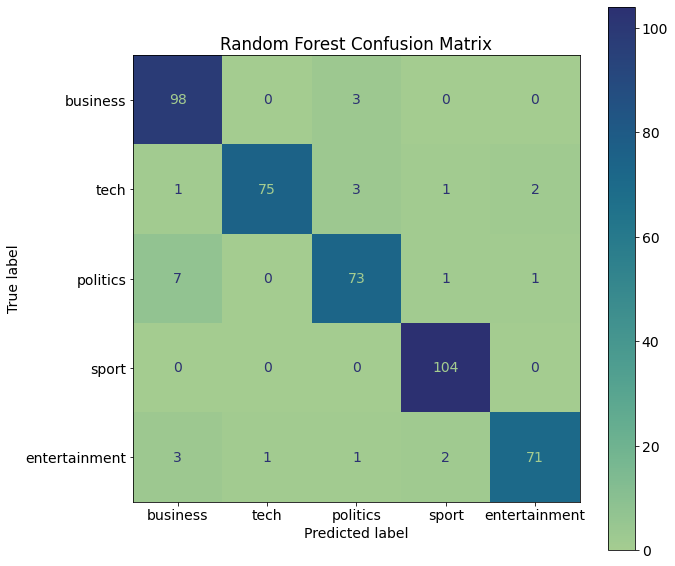

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
# cm = confusion_matrix(Y_test, test_predict)
disp = ConfusionMatrixDisplay.from_estimator(rfc,X_test,Y_test,cmap="crest", ax=ax,display_labels=target_category)
# disp.plot(ax=ax)
ax.set_title("Random Forest Confusion Matrix")

fig.savefig("CM")
plt.show()